# AI 모델 구현: 온도 및 전령량 예측

온도 및 사용된 전령량을 예측하고 각 센서의 예측값을 REST API로 통해 반환할 수 있도록 구현하였습니다.

---

## 1. Import

In [82]:
from influxdb_client import InfluxDBClient # type: ignore
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression # type: ignore
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from dotenv import load_dotenv
import os
from datetime import datetime

## 2. 데이터 준비

- ### 환경 변수 적용

In [11]:
# InfluxDB 접속 정보 불러오기
load_dotenv('parameters.env')

DB_URL = os.getenv('DB_URL')
DB_TOKEN = os.getenv('DB_TOKEN')
DB_ORG = os.getenv('DB_ORG')
DB_BUCKET = os.getenv('DB_BUCKET')

print('DB_URL',DB_URL)
print('DB_TOKEN',DB_TOKEN)
print('DB_ORG',DB_ORG)
print('DB_BUCKET',DB_BUCKET)

DB_URL http://180.210.83.241:8086/
DB_TOKEN pu3lGvm4S1TqTq0WBv2mRFDGqOvfhMxH4-hz33TSw8dh9xBZcRUnmTKfeH2Za2Oil6oMVyfYzI2A9zQvKoSfpQ==
DB_ORG databo3
DB_BUCKET raw_data


- ### InfluxDB에 접속하여 필요한 센서 데이터 가져오기

In [12]:
# dataset의 정보 출력
def print_df_info(dataset, sensor_type):
    pd.set_option('display.max_columns', None)  # Display all columns
    pd.set_option('display.max_rows', None)     # Display all rows
    pd.set_option('display.width', None)        # Set the display width to None

    print('='*30)
    print(dataset.info())
    print('='*30)
    print("Column Names: ",dataset.columns)
    print('='*30)
    print("Data types:\n",dataset.dtypes)
    print('='*30)
    print("Summary statistics:\n",dataset.describe())
    print('='*30)
    print(dataset.isnull().sum())
    print('='*30)
    print(dataset.head(30))
    print('='*30)
    print('Index of Dataframe: ',dataset.index.name)
    print('='*30)
    print(dataset.corr()[sensor_type].sort_values(ascending=False))

In [13]:
# dataset을 그래프로 표현
def draw_table(sensor_type, dataset):
    """
    데이터 프레임을 그래프로 표현합니다.
    
    Args:
        dataset (DataFrame): 그래프로 표현할 데이터 프레임.
    """

    plt.figure(figsize=(16,8))
    sns.lineplot(data=dataset, palette='Set1')
    plt.xlabel('Time')
    plt.ylabel(sensor_type)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [14]:
# 데이터 쿼리를 위한 시작 및 종료 시간을 반환
def start_end_time():
    now = datetime.now()
    start_time = now.replace(day=1, hour=0, minute=0, second=0, microsecond=0)

    start_iso = start_time.isoformat() + 'Z'
    end_iso = now.isoformat() + 'Z'

    return [start_iso, end_iso]

In [15]:
# 온도 데이터 가져오기
def query_sensor_data(client, bucket, branch, sensor_type):
    query_api = client.query_api()
    
    query = f'from(bucket: "{bucket}")\
        |> range(start: -7d)\
        |> filter(fn: (r) => r.branch == "{branch}")\
        |> filter(fn: (r) => r["endpoint"] == "{sensor_type}")\
        |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)\
        |> yield(name: "sensor_value")'
    
    print("Query: ",query)
    result_df = query_api.query_data_frame(query=query)
    return result_df

In [62]:
# 전력량 데이터 가져오기
def query_energy(client, bucket, branch, sensor_type):
    query_api = client.query_api()
    datetimes = start_end_time()
    
    query = f'from(bucket: "{bucket}")\
        |> range(start: {datetimes[0]}, stop: {datetimes[1]})\
        |> filter(fn: (r) => r["branch"] == "{branch}")\
        |> filter(fn: (r) => r["endpoint"] == "{sensor_type}")\
        |> filter(fn: (r) => r["phase"] == "total")\
        |> filter(fn: (r) => r["description"] == "w")\
        |> group(columns: ["site"])\
        |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)\
        |> yield(name: "sensor_value")'
    
    print("Query: ",query)
    result_df = query_api.query_data_frame(query=query)
    return result_df

In [63]:
# 환경 변수 선언
client = InfluxDBClient(url=DB_URL, token=DB_TOKEN, org=DB_ORG, timeout=30_000)
bucket = DB_BUCKET
branch = 'gyeongnam'

In [64]:
# 온도 데이터셋 준비
raw_df_temp = query_sensor_data(client, bucket, branch, 'temperature')

# 에너지 데이터셋 준비
raw_df_energy = query_energy(client, bucket, branch, 'electrical_energy')

client.close()

Query:  from(bucket: "raw_data")        |> range(start: -7d)        |> filter(fn: (r) => r.branch == "gyeongnam")        |> filter(fn: (r) => r["endpoint"] == "temperature")        |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)        |> yield(name: "sensor_value")


/home/sein/anaconda3/lib/python3.9/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    from(bucket: "raw_data")        |> range(start: -7d)        |> filter(fn: (r) => r.branch == "gyeongnam")        |> filter(fn: (r) => r["endpoint"] == "temperature")        |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)        |> yield(name: "sensor_value") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    - https://docs.influxdata.com/flux/latest/stdlib/universe/pivot/
    - https://docs.influxdata.com/flux/latest/stdli

Query:  from(bucket: "raw_data")        |> range(start: 2024-05-01T00:00:00Z, stop: 2024-05-09T09:19:52.828167Z)        |> filter(fn: (r) => r["branch"] == "gyeongnam")        |> filter(fn: (r) => r["endpoint"] == "electrical_energy")        |> filter(fn: (r) => r["phase"] == "total")        |> filter(fn: (r) => r["description"] == "w")        |> group(columns: ["site"])        |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)        |> yield(name: "sensor_value")


/home/sein/anaconda3/lib/python3.9/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    from(bucket: "raw_data")        |> range(start: 2024-05-01T00:00:00Z, stop: 2024-05-09T09:19:52.828167Z)        |> filter(fn: (r) => r["branch"] == "gyeongnam")        |> filter(fn: (r) => r["endpoint"] == "electrical_energy")        |> filter(fn: (r) => r["phase"] == "total")        |> filter(fn: (r) => r["description"] == "w")        |> group(columns: ["site"])        |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)        |> yield(name: "sensor_value") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For mo

In [65]:
print('='*30)
print(raw_df_temp.info())
print('='*30)
print("Column Names: ",raw_df_temp.columns)
print('='*30)
print("Data types:\n",raw_df_temp.dtypes)
print('='*30)
print("Summary statistics:\n",raw_df_temp.describe())
print('='*30)
print(raw_df_temp.isnull().sum())
print('='*30)
print(raw_df_temp.head(30))
print('='*30)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 0 to 1689
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype                  
---  ------        --------------  -----                  
 0   result        1690 non-null   object                 
 1   table         1690 non-null   int64                  
 2   _start        1690 non-null   datetime64[ns, tzutc()]
 3   _stop         1690 non-null   datetime64[ns, tzutc()]
 4   _time         1690 non-null   datetime64[ns, tzutc()]
 5   _value        1690 non-null   float64                
 6   _field        1690 non-null   object                 
 7   _measurement  1690 non-null   object                 
 8   branch        1690 non-null   object                 
 9   device        1690 non-null   object                 
 10  endpoint      1690 non-null   object                 
 11  place         1690 non-null   object                 
 12  site          1690 non-null   object                 
dtypes: 

In [66]:
print('='*30)
print(raw_df_energy.info())
print('='*30)
print("Column Names: ",raw_df_energy.columns)
print('='*30)
print("Data types:\n",raw_df_energy.dtypes)
print('='*30)
print("Summary statistics:\n",raw_df_energy.describe())
print('='*30)
print(raw_df_energy.isnull().sum())
print('='*30)
print(raw_df_energy.head(30))
print('='*30)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2307 entries, 0 to 2306
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype                  
---  ------  --------------  -----                  
 0   result  2307 non-null   object                 
 1   table   2307 non-null   int64                  
 2   _time   2307 non-null   datetime64[ns, tzutc()]
 3   _start  2307 non-null   datetime64[ns, tzutc()]
 4   _stop   2307 non-null   datetime64[ns, tzutc()]
 5   site    2307 non-null   object                 
 6   _value  2307 non-null   float64                
dtypes: datetime64[ns, tzutc()](3), float64(1), int64(1), object(2)
memory usage: 144.2+ KB
None
Column Names:  Index(['result', 'table', '_time', '_start', '_stop', 'site', '_value'], dtype='object')
Data types:
 result                     object
table                       int64
_time     datetime64[ns, tzutc()]
_start    datetime64[ns, tzutc()]
_stop     datetime64[ns, tzutc()]
site                       object

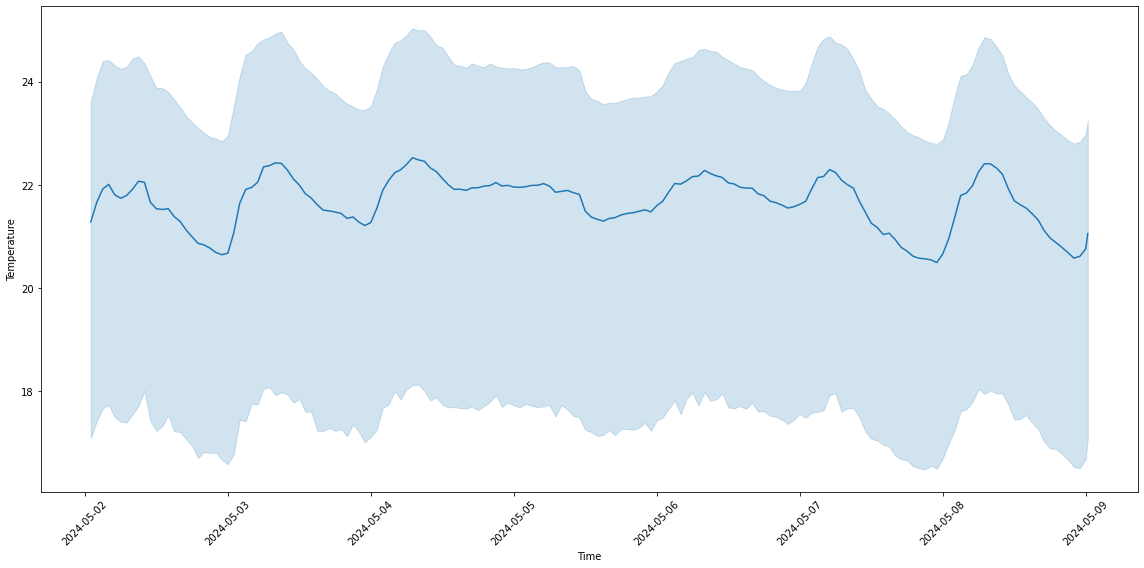

In [67]:
plt.figure(figsize=(16,8))
sns.lineplot(x='_time',y='_value',data=raw_df_temp, palette='Set1')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

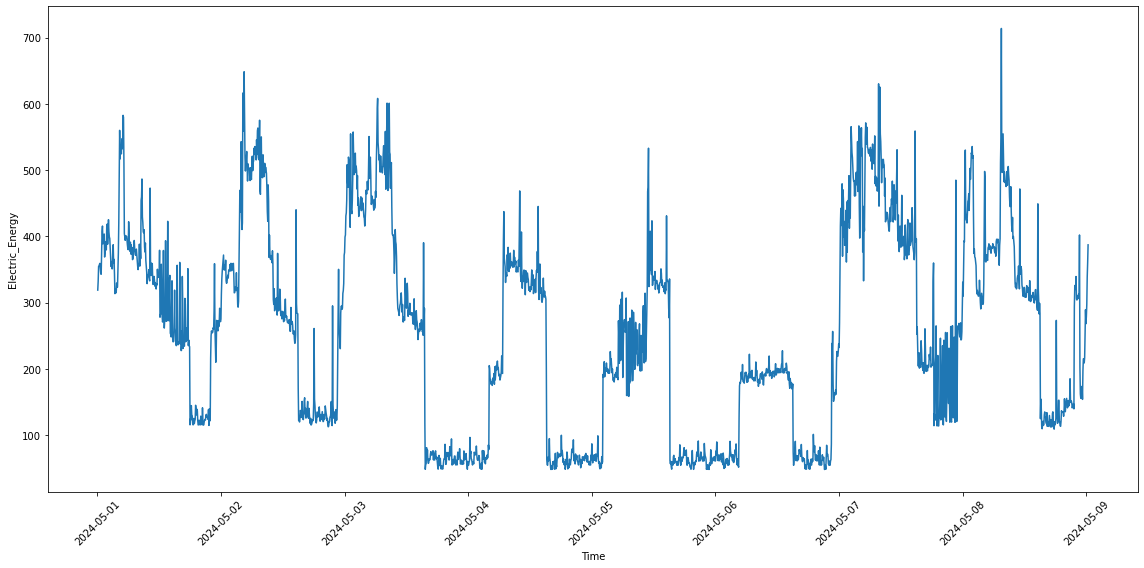

In [68]:
plt.figure(figsize=(16,8))
sns.lineplot(x='_time',y='_value',data=raw_df_energy, palette='Set1')
plt.xlabel('Time')
plt.ylabel('Electric_Energy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- ### 데이터 전처리

In [69]:
# 이상치 제거
def outlier_processing(raw_dataset, sensor_type):
    raw_dataset[sensor_type] = raw_dataset[sensor_type].interpolate()   
    fig = plt.figure()

    fig_1 = fig.add_subplot(1,2,1)
    fig_2 = fig.add_subplot(1,2,2)

    fig_1.set_title('Original Data Boxplot')
    fig_1.boxplot(raw_dataset)
    
    print('-'*30)
    print(np.percentile(raw_dataset,25))
    print(np.percentile(raw_dataset,50))
    print(np.median(raw_dataset))
    print(np.percentile(raw_dataset,75))

    iqr_value = np.percentile(raw_dataset,75) - np.percentile(raw_dataset,25)
    print('IQR_value : {}'.format(iqr_value))

    upper_bound = iqr_value * 1.5 + np.percentile(raw_dataset, 75)
    print('upper_bound : {}'.format(upper_bound)) # 보다 큰 값은 이상치

    lower_bound = np.percentile(raw_dataset,25) - iqr_value * 1.5
    print('lower_bound : {}'.format(lower_bound)) # 보다 작은 값은 이상치

    # 우리 데이터에서 이상치를 출력
    print(raw_dataset[(raw_dataset > upper_bound) | (raw_dataset < lower_bound)])

    result_data = raw_dataset[(raw_dataset<=upper_bound) & (raw_dataset >= lower_bound)]
    result_data[sensor_type] = result_data[sensor_type].interpolate()
    print('이상치 제거 후 데이터 : {}'.format(result_data))
    print('-'*30)

    fig_2.set_title('Remove Outlier Data Boxplot')
    fig_2.boxplot(result_data)

    fig.tight_layout()
    plt.show()

    return result_data

In [70]:
# 데이터 전처리
def data_preprocessing(sensor_type, raw_dataset):
    # dataframe 중요한 column 가져오기
    if 'place' in raw_dataset.columns:
        df = raw_dataset[['_time', 'place', '_value']].copy()
        
        # 냉장고 지우기
        if '냉장고' in df['place'].values:
            df = df[df['place'] != '냉장고']
        
        df = df.drop(columns=['place'])
    else:
        df = raw_dataset[['_time', '_value']].copy()
    
    # 기존 column 이름 변경하기
    df.rename(columns={'_time':'date'}, inplace=True)
    df.rename(columns={'_value': sensor_type}, inplace=True)

    # date asia 시간대로 바꾸기
    df['date'] = pd.to_datetime(df['date']).dt.tz_convert('Asia/Seoul').dt.tz_localize(None)

    # date를 index로 set하기
    df = df.set_index('date')

    # 결측지를 전체의 평균값으로 채우기
    df = outlier_processing(df, sensor_type)        

    # 가공된 dataframe의 정보 출력
    print_df_info(df, sensor_type)
    
    return df

------------------------------
23.177419354838715
23.708064516129053
23.708064516129053
24.16666666666666
IQR_value : 0.9892473118279455
upper_bound : 25.65053763440858
lower_bound : 21.693548387096797
                            temperature
date                                   
2024-05-02 10:00:00.000000          NaN
2024-05-02 11:00:00.000000          NaN
2024-05-02 12:00:00.000000          NaN
2024-05-02 13:00:00.000000          NaN
2024-05-02 14:00:00.000000          NaN
2024-05-02 15:00:00.000000          NaN
2024-05-02 16:00:00.000000          NaN
2024-05-02 17:00:00.000000          NaN
2024-05-02 18:00:00.000000          NaN
2024-05-02 19:00:00.000000          NaN
2024-05-02 20:00:00.000000          NaN
2024-05-02 21:00:00.000000          NaN
2024-05-02 22:00:00.000000          NaN
2024-05-02 23:00:00.000000          NaN
2024-05-03 00:00:00.000000          NaN
2024-05-03 01:00:00.000000          NaN
2024-05-03 02:00:00.000000          NaN
2024-05-03 03:00:00.000000          Na

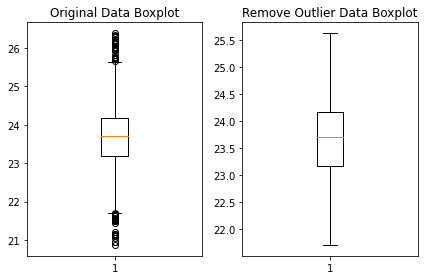

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1521 entries, 2024-05-02 10:00:00 to 2024-05-09 09:19:51.684979
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  1521 non-null   float64
dtypes: float64(1)
memory usage: 23.8 KB
None
Column Names:  Index(['temperature'], dtype='object')
Data types:
 temperature    float64
dtype: object
Summary statistics:
        temperature
count  1521.000000
mean     23.702458
std       0.839864
min      21.709524
25%      23.177419
50%      23.708065
75%      24.166667
max      25.626667
temperature    0
dtype: int64
                     temperature
date                            
2024-05-02 10:00:00    24.010000
2024-05-02 11:00:00    24.570000
2024-05-02 12:00:00    25.033333
2024-05-02 13:00:00    25.176667
2024-05-02 14:00:00    25.072414
2024-05-02 15:00:00    25.016667
2024-05-02 16:00:00    25.030000
2024-05-02 17:00:00    25.020690
2024-05-02 18:00:00    

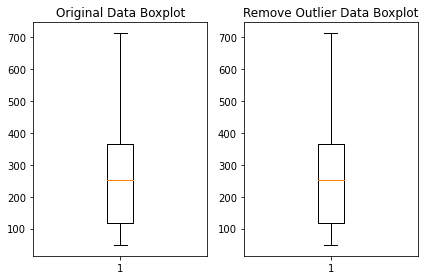

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2307 entries, 2024-05-01 09:05:00 to 2024-05-09 09:20:00
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   electrical_energy  2307 non-null   float64
dtypes: float64(1)
memory usage: 36.0 KB
None
Column Names:  Index(['electrical_energy'], dtype='object')
Data types:
 electrical_energy    float64
dtype: object
Summary statistics:
        electrical_energy
count        2307.000000
mean          254.055770
std           151.198773
min            48.158621
25%           117.848276
50%           253.841379
75%           367.072414
max           713.834483
electrical_energy    0
dtype: int64
                     electrical_energy
date                                  
2024-05-01 09:05:00         318.896552
2024-05-01 09:10:00         332.234483
2024-05-01 09:15:00         354.717241
2024-05-01 09:20:00         354.876033
2024-05-01 09:25:00         357.7301

In [71]:
# 온도 데이터 전처리
pre_df_temp = data_preprocessing('temperature', raw_df_temp)

# 에너지 데이터 전처리
pre_df_energy = data_preprocessing('electrical_energy', raw_df_energy)

## 3. 모델 학습 (Linear Regression)

- ### 데이터셋 분할 및 모델 학습

In [72]:
models = {}
X_tests = {}
y_tests = {}
predictions = {}
accuracies = {}

In [73]:
# 선형 회귀 모델 학습
def train_lr_model(sensor_type, df):
    # linear regression model용 dataset 만들기
    split_ratio = int(len(df) * 0.9)
    lr_df = df
    lr_df[sensor_type+'.L1'] = lr_df[sensor_type].shift(1)
    lr_df.dropna(inplace=True)
    lr_y = lr_df[sensor_type]
    lr_X = lr_df.drop(columns=sensor_type)
    X_train, y_train = lr_X.iloc[:split_ratio], lr_y.iloc[:split_ratio]
    X_test, y_test = lr_X.iloc[split_ratio:], lr_y.iloc[split_ratio:]

    y_pred_baseline = [y_train.mean()] * len(y_train)
    mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
    print("Mean Close Prices:", round(y_train.mean(), 2))
    print("Baseline MAE:", round(mae_baseline, 2))
    print('-'*30)
    print('LR X_test : ', X_test[:10])
    print('LR X_test type :', type(X_test))

    # 모델 생성 및 학습
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    X_tests[sensor_type] = X_test
    y_tests[sensor_type] = y_test
    models[sensor_type] = lr_model
    predictions[sensor_type] = pd.Series(lr_model.predict(X_test), index=y_test.index)

In [74]:
train_lr_model('temperature', pre_df_temp)
train_lr_model('electrical_energy', pre_df_energy)

Mean Close Prices: 23.7
Baseline MAE: 0.66
------------------------------
LR X_test :                       temperature.L1
date                               
2024-05-03 03:00:00       22.735484
2024-05-03 04:00:00       22.498413
2024-05-03 05:00:00       22.394915
2024-05-03 06:00:00       22.308065
2024-05-03 07:00:00       22.161290
2024-05-03 08:00:00       22.059677
2024-05-03 09:00:00       22.009375
2024-05-03 10:00:00       22.064179
2024-05-03 11:00:00       22.760000
2024-05-03 12:00:00       23.639394
LR X_test type : <class 'pandas.core.frame.DataFrame'>
Mean Close Prices: 251.28
Baseline MAE: 132.54
------------------------------
LR X_test :                       electrical_energy.L1
date                                     
2024-05-08 14:15:00            380.668966
2024-05-08 14:20:00            383.050000
2024-05-08 14:25:00            385.719008
2024-05-08 14:30:00            376.710345
2024-05-08 14:35:00            374.586207
2024-05-08 14:40:00            383.737931

- ### 모델 평가

In [75]:
# 모델 평가
def evaluate_models():
    for name, prediction in predictions.items():
        evs = explained_variance_score(y_tests[name], prediction)
        mae = mean_absolute_error(y_tests[name], prediction)
        mse = mean_squared_error(y_tests[name], prediction)
        rmse = mean_squared_error(y_tests[name], prediction, squared=False)
        r2 = r2_score(y_tests[name], prediction)

        accuracies[name] = {'Explained Variance': evs,
                            'Mean Absolute Error': mae,
                            'Mean Squared Error': mse,
                            'Root Mean Squared Error': rmse,
                            'R² Score': r2}

In [78]:
# 예측 그래프으로 그리기
def draw_prediction(sensor_type, model_name, X_test, y_test, y_pred):
    X_test_sorted = y_test.index
    y_test_sorted = y_test
    y_pred_sorted = y_pred

    if model_name=='RandomForest':
        sorted_indices = np.argsort(X_test[:, 0])
        X_test_sorted = X_test[sorted_indices]
        y_test_sorted = y_test.iloc[sorted_indices]
        y_pred_sorted = y_pred[sorted_indices]

    plt.figure()
    plt.plot(X_test_sorted, y_test_sorted, label='Actual Values')
    plt.plot(X_test_sorted, y_pred_sorted, label='Predicted Values')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Date')
    plt.ylabel(sensor_type)
    plt.legend()
    plt.grid()
    plt.show()

In [79]:
evaluate_models()

In [80]:
# 점수 출력
print('EVALUATION SCORES: ')
for sensor, models in accuracies.items():
    print(f"Sensor: {sensor}")
    for model, scores in models.items():
        print(f"{model}: {scores}")
    print('-'*30)

EVALUATION SCORES: 
Sensor: temperature
Explained Variance: 0.9101802782148912
Mean Absolute Error: 0.18891040661598507
Mean Squared Error: 0.07102681138180604
Root Mean Squared Error: 0.26650855780219523
R² Score: 0.9101767475630431
------------------------------
Sensor: electrical_energy
Explained Variance: 0.908409871620583
Mean Absolute Error: 18.80056355493337
Mean Squared Error: 1501.2474083060376
Root Mean Squared Error: 38.74593408741151
R² Score: 0.9083733313228032
------------------------------


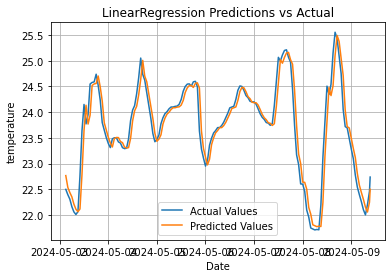

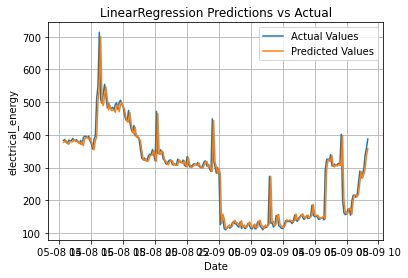

In [81]:
for sensor, models in accuracies.items():
    draw_prediction(sensor, 'LinearRegression', X_tests[sensor], y_tests[sensor], predictions[sensor])

'''bash
curl -X POST 'http://127.0.0.1:5000/predict/temp' -d '{"dates":["2024-05-09 00:00:00","2024-05-09 00:01:00"], "values":[21.00, 21.4]}' -H "Content-Type: application/json"
'''

'''bash
curl -X POST 'http://127.0.0.1:5000/predict/temp' -d '{"dates":["2024-05-03 00:00:00.000000000","2024-05-03 01:00:00.000000000","2024-05-03 02:00:00.000000000","2024-05-03 03:00:00.000000000","2024-05-03 04:00:00.000000000","2024-05-03 05:00:00.000000000","2024-05-03 06:00:00.000000000","2024-05-03 07:00:00.000000000","2024-05-03 08:00:00.000000000","2024-05-03 09:00:00.000000000","2024-05-03 10:00:00.000000000","2024-05-03 11:00:00.000000000","2024-05-03 12:00:00.000000000","2024-05-03 13:00:00.000000000","2024-05-03 14:00:00.000000000","2024-05-03 15:00:00.000000000","2024-05-03 16:00:00.000000000","2024-05-03 17:00:00.000000000","2024-05-03 18:00:00.000000000","2024-05-03 19:00:00.000000000","2024-05-03 20:00:00.000000000","2024-05-03 21:00:00.000000000","2024-05-03 22:00:00.000000000","2024-05-03 23:00:00.000000000"]}' -H "Content-Type: application/json"
'''